In [58]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import igraph
from igraph import Graph, EdgeSeq
import plotly.graph_objects as go

In [59]:
mov = 0.5 # tamanio de paso del robot
expandidos = []

origen = [5,0]
meta = [8,8]

In [60]:
def get_nodos(raiz):
    nodos = []
    por_visitar = [raiz]
    visitados = []

    while por_visitar != []:
        nodo = por_visitar.pop(0)
        if (nodo in visitados) or (nodo in nodos):
            continue
        nodos.append(nodo)
        por_visitar += nodo.hijos
        visitados.append(nodo)

    return nodos

In [61]:
def get_etiquetas(nodos):
    labels = []
    for nodo in nodos:
        labels.append(
            str(nodo.pos)
        )
    return labels

In [62]:
def crear_grafo(nodos, etiquetas):
    
    g = Graph(directed = True)

    for nodo in nodos:
        g.add_vertex(etiquetas[nodos.index(nodo)])
    padre_hijo = []
    for nodo in nodos:
        
        padre_hijo.append([nodo.papa, nodo])
    for r in padre_hijo:
        if r[0]:  # tiene papa
            g.add_edge(etiquetas[nodos.index(r[0])], etiquetas[nodos.index(r[1])])

    edges = [e.tuple for e in g.es]
    
    return g, edges

In [63]:
def dibujar_grafo(grafo, labels, title):
    # Encontrar raíz: nodo sin padres (grado de entrada 0)
    raices = [v.index for v in grafo.vs if grafo.degree(v, mode="in") == 0]
    if len(raices) != 1:
        return f"SHay {len(raices)}, imposible ejecutar"
    root_idx = raices[0]

    layout = grafo.layout_reingold_tilford(mode="out", root=[root_idx]) # out, que no se graficque hacia los lados, sino hacia abajo

    Xn = [pos[0] for pos in layout]
    Yn = [-pos[1] for pos in layout]  # y negativa: hacia abajo

    Xe, Ye = [], []
    for edge in grafo.get_edgelist():
        Xe += [Xn[edge[0]], Xn[edge[1]], None]
        Ye += [Yn[edge[0]], Yn[edge[1]], None]

    trace_edges = go.Scatter(
        x=Xe, y=Ye,
        mode='lines',
        line=dict(width=1, color='gray'),
        hoverinfo='none'
    )

    trace_nodes = go.Scatter(
        x=Xn, y=Yn,
        mode='markers',
        marker=dict(symbol="circle-dot", size=30, color="lightblue", line=dict(width=2)),
        text=labels,
        textposition="middle center",
        hoverinfo="text"
    )

    fig = go.Figure(data=[trace_edges, trace_nodes],
                    layout=go.Layout(title=title,
                                     showlegend=True,
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False),
                                     yaxis=dict(showgrid=False, zeroline=False)))
    fig.show()

In [64]:
def dibujar_grafo_anim(grafo, labels, title):
    raices = [v.index for v in grafo.vs if grafo.degree(v, mode="in") == 0]
    if len(raices) != 1:
        raise ValueError(f"Se esperaba 1 raíz, pero hay {len(raices)}")

    root_idx = raices[0]
    layout = grafo.layout_reingold_tilford(mode="out", root=[root_idx])
    Xn = [pos[0] for pos in layout]
    Yn = [-pos[1] for pos in layout]

    # Preparar nodos y aristas para cada frame
    frames = []
    num_nodos = len(grafo.vs)
    for i in range(1, num_nodos + 1):
        # Aristas visibles hasta este nodo
        Xe, Ye = [], []
        for edge in grafo.get_edgelist():
            if edge[0] < i and edge[1] < i:
                Xe += [Xn[edge[0]], Xn[edge[1]], None]
                Ye += [Yn[edge[0]], Yn[edge[1]], None]

        trace_edges = go.Scatter(
            x=Xe, y=Ye,
            mode='lines',
            line=dict(width=1, color='gray'),
            hoverinfo='none'
        )

        trace_nodes = go.Scatter(
            x=Xn[:i], y=Yn[:i],
            mode='markers',
            marker=dict(symbol="circle-dot", size=30, color="lightblue", line=dict(width=2)),
            text=labels[:i],
            textposition="middle center",
            hoverinfo="text"
        )

        frames.append(go.Frame(data=[trace_edges, trace_nodes], name=str(i)))

    # Frame inicial
    initial_edges = go.Scatter(x=[], y=[], mode='lines')
    initial_nodes = go.Scatter(x=[], y=[], mode='markers')

    fig = go.Figure(
        data=[initial_edges, initial_nodes],
        layout=go.Layout(
            title=title,
            showlegend=True,
            margin=dict(b=20, l=7, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False),
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label=" > Reproducir",
                              method="animate",
                              args=[None, {"frame": {"duration": 500, "redraw": True},
                                           "fromcurrent": True, "transition": {"duration": 0}}])],
                showactive=False,
                x=0.1, y=-0.1
            )]
        ),
        frames=frames
    )

    fig.show()

In [65]:
def dibujar(gp):
    plt.grid(True)
    plt.scatter(gp[0], gp[1], c="r") # dibula la posicion del punto
    plt.plot([0,0,10, 10,0], [0,10,10,0,0], c="k") # dibujamos un cuadro delimitando el espacio de trabajo

In [66]:
class Obstaculo():
    def __init__(self, v1, v2):
        self.v1 = v1 # esquina superior
        self.v2 = v2 # esquina inferior

    def en_colision(self, punto):
        if self.v1[0] <= punto[0] <= self.v2[0] and self.v2[1] <= punto[1] <= self.v1[1]:
            return True
        return False
    
    def dibuja(self):
        x = [self.v1[0], self.v2[0], self.v2[0], self.v1[0], self.v1[0]]
        y = [self.v1[1], self.v1[1], self.v2[1], self.v2[1], self.v1[1]]
        plt.plot(x,y, "--k")

In [67]:
def es_punto_valido(punto, obstaculos, limites):
    # esta en el limite permitido?
    if limites[0] <= punto[0] <= limites[2] and limites[1] <= punto[1] <= limites[3] :
        # Hay colision
        for o in obstaculos:
            if o.en_colision(punto):
                return False
        return True
    return False

In [68]:
class Nodo():
    def __init__(self, pos, papa = None):
        self.pos = pos
        self.hijos = []
        self.papa = papa
        if self not in expandidos:
            expandidos.append(self)

    def genera_hijos(self, obstaculos, limites):
        global expandidos
        
        # uno arriba
        pos_arriba = self.pos[:]
        pos_arriba[1] += mov

        # uno abajo
        pos_abajo = self.pos[:]
        pos_abajo[1] -= mov
        
        # uno izq
        pos_izq = self.pos[:]
        pos_izq [0] -= mov
        
        # uno der
        pos_der = self.pos[:]
        pos_der[0] += mov
        
        if es_punto_valido(pos_arriba, obstaculos, limites):
            # self.hijos.append(Nodo(pos_arriba, self))
            hijo = self.__class__(pos_arriba, self)
            # if hijo not in expandidos:
            #     expandidos.append(hijo)
            self.hijos.append(hijo)

        if es_punto_valido(pos_abajo, obstaculos, limites):
            hijo = self.__class__(pos_abajo, self)
            # if hijo not in expandidos:
            #     expandidos.append(hijo)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_izq, obstaculos, limites):
            hijo = self.__class__(pos_izq, self)
            # if hijo not in expandidos:
            #     expandidos.append(hijo)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_der, obstaculos, limites):
            hijo = self.__class__(pos_der, self)
            # if hijo not in expandidos:
            #     expandidos.append(hijo)
            self.hijos.append(hijo)

    def __eq__(self, n2):
        return self.pos == n2.pos

    def __str__(self):
        s = f"{self.pos[0]}, {self.pos[1]}"
        return s

    def bpp(self, meta, robot, visitados = []):
        
        if self in visitados:
            return None
        
        if self.pos == meta:
            return [self]

        self.genera_hijos(robot.obstaculos, robot.limites)
        visitados.append(self)

        for h in self.hijos:
            resp = h.bpp(meta, robot, visitados)
            if resp:
                resp.append(self)
                return resp
        
        return None

    def bpa(self, meta, robot, visitados = []):
        
        if self.pos == meta:
            return [self]
        
        if self in visitados:
            return None
        
        self.genera_hijos(robot.obstaculos, robot.limites)
        visitados.append(self)

        por_visitar = self.hijos[:]

        while por_visitar!= []:
            h = por_visitar.pop(0)

            if h in visitados:
                continue

            #expandidos.append(h)
            
            if h.pos == meta:
                camino = [h]
                papa = h.papa
                while papa:
                    camino.append(papa)
                    papa = papa.papa
                print("camino guardado...")
                print
                camino.reverse()
                return camino
            
            h.genera_hijos(robot.obstaculos, robot.limites)
            visitados.append(h)
            por_visitar += h.hijos
        
        return None

In [69]:
class Robot():
    def __init__(self, pos = [5,5], limites = [0,0,10,10], obstaculos = []):
        self.pos = pos
        self.limites = limites
        self.obstaculos = obstaculos
        self.trajectory = []
        self.raiz = None
    
    def agrega_obstaculo(self, obs):
        self.obstaculos.append(obs)

    def plot_robot(self):
        plt.scatter(self.pos[0], self.pos[1], c="b")

    def BPP(self, meta, visitados = []):
        self.raiz = Nodo(self.pos)
        expandidos.append(self.raiz)
        camino = self.raiz.bpp(meta, self)
        camino.reverse()
        self.trajectory = []
        for paso in camino:
            self.trajectory += paso.pos
        return camino

    def BPA(self, meta, visitados = []):
        self.raiz = Nodo(self.pos)
        expandidos.append(self.raiz)
        camino = self.raiz.bpa(meta, self)
        self.trajectory = []

        for paso in camino:
            self.trajectory += paso.pos
        return camino

In [70]:
class NodoHeuristica(Nodo):
    def __init__(self, pos, papa = None):
        super(NodoHeuristica, self).__init__(pos, papa)
        if papa:
            self.costo = papa.costo + 1 # del nodo padre a este nodo
        else:
            self.costo = 0
        self.h = float("inf")

        if self not in expandidos:
            expandidos.append(self)

    
    def heuristica(self, meta):
        self.h = abs(self.pos[0] - meta[0]) + abs(self.pos[1] - meta[1])
        return self.h
    
    def f_n(self, meta):
        self.h = abs(self.pos[0] - meta[0]) + abs(self.pos[1] - meta[1]) + self.costo
        return self.h

    def bgreedy(self, meta, robot):
        print(f"tipo greedy: {type(self)}")
        visitados = []
        franja = [self] # por visitar
        while franja != []:
            h = franja.pop(0)
            if h in visitados:
                continue

            #expandidos.append(h)

            if h.pos == meta:
                print("metaaaaaaa")
                camino = [h]
                papa = h.papa
                while papa:
                    camino.append(papa)
                    papa = papa.papa
                camino.reverse()
                return camino
            
            h.genera_hijos(robot.obstaculos, robot.limites)
            
            for i in h.hijos:
                i.heuristica(meta)
            
            franja += h.hijos
            franja.sort()
            visitados.append(h)


    def astar(self, meta, robot):
              
        visitados = []
        franja = [self] # por visitar
        while franja != []:
            h = franja.pop(0)

            if h in visitados:
                continue
            
            #expandidos.append(h)

            if h.pos == meta:
                print("metaaaaaaa")
                camino = [h]
                papa = h.papa
                while papa:
                    camino.append(papa)
                    papa = papa.papa
                camino.reverse()
                return camino
            
            h.genera_hijos(robot.obstaculos, robot.limites)
            
            for i in h.hijos:
                i.f_n(meta)
            
            franja += h.hijos
            franja.sort()
            visitados.append(h)


    def __lt__(self, n2):
        return self.h < n2.h

In [71]:
class RobotHeur(Robot, Nodo):
    
    def __init__(self, pos=[5, 5], limites=[0, 0, 10, 10], obstaculos=[]):
        super(RobotHeur, self).__init__(pos, limites, obstaculos)
        self.raiz = NodoHeuristica(self.pos)

    def BGREEDY(self, meta):
        self.raiz = NodoHeuristica(self.pos)
        expandidos.append(self.raiz)
        camino = self.raiz.bgreedy(meta, self)
        if camino:
            self.trajectory = []
            for paso in camino:
                self.trajectory += paso.pos
        else:
            print("Camino no encontrado")
        return camino

    def ASTAR(self, meta):
        self.raiz = NodoHeuristica(self.pos)
        expandidos.append(self.raiz)
        camino = self.raiz.astar(meta, self)
        if camino:
            self.trajectory = []
            for paso in camino:
                self.trajectory += paso.pos
        else:
            print("Camino no encontrado")
        return camino

In [72]:
def plot_space_simple(robot, expandidos, title):
    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    robot.plot_robot()

    for p in expandidos:
        plt.scatter(p.pos[0], p.pos[1], c="k")

    plt.plot(robot.trajectory[0::2], robot.trajectory[1::2], "o-b")

    dibujar([8,8])

    plt.title(title)
    plt.grid(visible=True)


In [73]:
def plot_space_animado(robot, expandidos, title):
    # Creamos la figura y los ejes
    fig, ax = plt.subplots()

    x_points = robot.trajectory[0::2]
    y_points = robot.trajectory[1::2]
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)

    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    

    # Línea inicial vacía
    line, = ax.plot([], [], "o-b")
    exp = ax.scatter([], [])
    


    # Función de inicialización
    def init():
        line.set_data([], [])
        exp.set_offsets(np.empty((0, 2)))
        dibujar(meta)
        robot.plot_robot()
        return line,

    def update(frame):

        x_data = x_points[:frame]
        y_data = y_points[:frame]
        line.set_data(x_data, y_data)

        x_exp = []
        y_exp = []

        porcentaje = frame / len(x_points)
        num_expandidos = int(len(expandidos) * porcentaje)

        for nodo in expandidos[:num_expandidos]:
            x_exp.append(nodo.pos[0])
            y_exp.append(nodo.pos[1])
        exp.set_color("y")
        exp.set_offsets(np.c_[x_exp, y_exp])
        
        return line, exp

    # Creamos la animación
    ani = FuncAnimation(
        fig, update, frames=len(x_points),
        init_func=init, blit=True, interval=100
    )

    plt.title(title)
    plt.grid(visible=True)
    # Mostramos la animación
    plt.show()

In [74]:
def ejecutar_BPP(origen, meta):
    global expandidos
    expandidos = []

    wall_E_BPP = Robot(origen)
    wall_E_BPP.agrega_obstaculo(Obstaculo([6,6],[10,2]))
    wall_E_BPP.agrega_obstaculo(Obstaculo([5,9],[7,7]))
    wall_E_BPP.agrega_obstaculo(Obstaculo([4,6],[5,4]))

    camino = wall_E_BPP.BPP(meta=meta)
    plot_space(wall_E_BPP, expandidos, "Camino del robot con BPP")
    print(f"Expandidos {len(expandidos)}")

    nodos = get_nodos(wall_E_BPP.raiz)
    etiquetas = get_etiquetas(nodos)
    grafo, uniones = crear_grafo(nodos, etiquetas)
    print(f"Expandidos {len(nodos)}")

    dibujar_grafo_anim(grafo, etiquetas, "Arbol BPP")

def ejecutar_BPA(origen, meta):
    global expandidos
    expandidos = []

    wall_E_BPA = Robot(origen)
    wall_E_BPA.agrega_obstaculo(Obstaculo([6,6],[10,2]))
    wall_E_BPA.agrega_obstaculo(Obstaculo([5,9],[7,7]))
    wall_E_BPA.agrega_obstaculo(Obstaculo([4,6],[5,4]))

    camino = wall_E_BPA.BPA(meta=meta)
    plot_space(wall_E_BPA, expandidos, "Camino del robot con BPA")
    print(f"Expandidos {len(expandidos)}")

    nodos = get_nodos(wall_E_BPA.raiz)
    etiquetas = get_etiquetas(nodos)
    grafo, uniones = crear_grafo(nodos, etiquetas)
    print(f"Expandidos {len(nodos)}")

    dibujar_grafo_anim(grafo, etiquetas, "Arbol BPA")

def ejecutar_GREEDY(origen, meta):
    global expandidos
    expandidos = []

    wall_E_GREEDY = RobotHeur(origen)
    wall_E_GREEDY.agrega_obstaculo(Obstaculo([6,6],[10,2]))
    wall_E_GREEDY.agrega_obstaculo(Obstaculo([5,9],[7,7]))
    wall_E_GREEDY.agrega_obstaculo(Obstaculo([4,6],[5,4]))

    camino = wall_E_GREEDY.BGREEDY(meta=meta)
    plot_space_animado(wall_E_GREEDY, expandidos, "Camino del robot con GREEDY")
    print(f"Expandidos {len(expandidos)}")

    nodos = get_nodos(wall_E_GREEDY.raiz)
    etiquetas = get_etiquetas(nodos)
    grafo, uniones = crear_grafo(nodos, etiquetas)
    print(f"Expandidos {len(nodos)}")

    dibujar_grafo_anim(grafo, etiquetas, "Arbol GREEDY")

In [ ]:
def ejecutar_ASTAR(origen, meta):
    global expandidos
    expandidos = []

    wall_E_ASTAR = RobotHeur(origen)
    wall_E_ASTAR.agrega_obstaculo(Obstaculo([6,6],[10,2]))
    wall_E_ASTAR.agrega_obstaculo(Obstaculo([5,9],[7,7]))
    wall_E_ASTAR.agrega_obstaculo(Obstaculo([4,6],[5,4]))

    camino = wall_E_ASTAR.ASTAR(meta=meta)

    """
    Alternar entre plot_space_simple y plot_space_animated si no se visualiza en la notebook 
    """
    plot_space_simple(wall_E_ASTAR, expandidos, "Camino del robot con A*")
    print(f"Expandidos {len(expandidos)}")

    nodos = get_nodos(wall_E_ASTAR.raiz)
    etiquetas = get_etiquetas(nodos)
    grafo, uniones = crear_grafo(nodos, etiquetas)
    print(f"Expandidos {len(nodos)}")

    """
    Alternar entre dibujar_grafo y dibujar_grafo_anim si no se visualiza en la notebook 
    """
    dibujar_grafo_anim(grafo, etiquetas, "Arbol A*")

metaaaaaaa
Expandidos 154
Expandidos 153


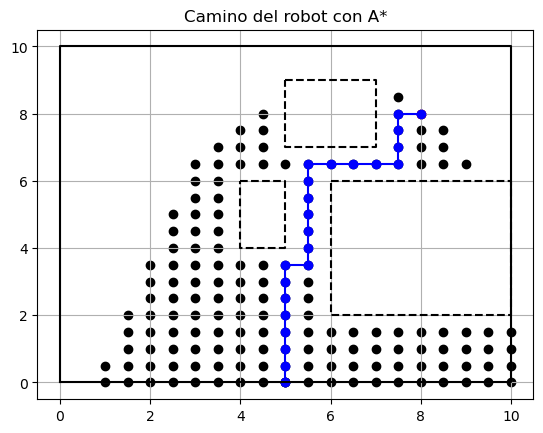

In [76]:
ejecutar_ASTAR(origen, meta)